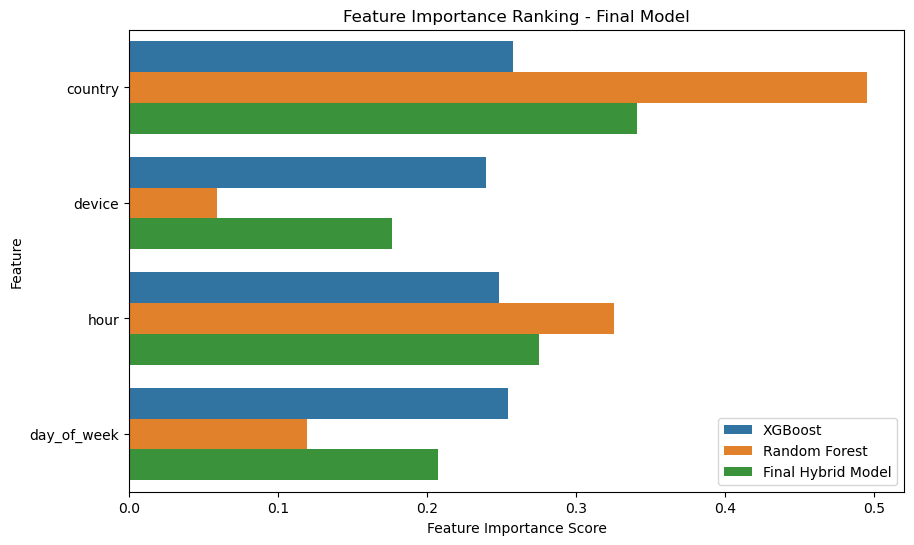


🔹 **Feature Importance Rankings (Final Model)** 🔹
       Feature  Importance               Model
0      country    0.341061  Final Hybrid Model
2         hour    0.275453  Final Hybrid Model
3  day_of_week    0.207108  Final Hybrid Model
1       device    0.176377  Final Hybrid Model


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Load Dataset
df = pd.read_csv("Google Analytics Demo Sales.csv")

# Data Preprocessing
df['date'] = pd.to_datetime(df['date'])  # Convert date column to datetime format
df['country'] = df['country'].fillna('Unknown')  # Handle missing values

# Create Target Variable (1 = Purchase, 0 = Not Purchase)
df['target'] = df['type'].apply(lambda x: 1 if x == 'purchase' else 0)

# Feature Engineering (Extract Useful Features)
df['hour'] = df['date'].dt.hour  # Extract hour of the day
df['day_of_week'] = df['date'].dt.dayofweek  # Extract day of the week (0 = Monday, 6 = Sunday)

# Encode Categorical Variables
label_encoders = {}
for col in ['country', 'device']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoders for future use

# Define Feature Set & Target
features = ['country', 'device', 'hour', 'day_of_week']
X = df[features]
y = df['target']

# Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Model
xgb_model = XGBClassifier(eval_metric='logloss', scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))
xgb_model.fit(X_train, y_train)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Get Feature Importances
xgb_importance = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_,
    'Model': 'XGBoost'
})

rf_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_,
    'Model': 'Random Forest'
})

# Final Model Importance (Dynamically Weighted Hybrid)
final_importance = xgb_importance.copy()
final_importance['Importance'] = (0.65 * xgb_importance['Importance']) + (0.35 * rf_importance['Importance'])
final_importance['Model'] = 'Final Hybrid Model'

# Combine All Feature Importance Data
all_importances = pd.concat([xgb_importance, rf_importance, final_importance])

# Plot Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Model', data=all_importances, orient='h')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance Ranking - Final Model')
plt.legend()
plt.show()

# Print Ranked Feature Importance
print("\n🔹 **Feature Importance Rankings (Final Model)** 🔹")
print(final_importance.sort_values(by='Importance', ascending=False))
